In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Importing DataLoaders for each model. These models include rule-based, vanilla DQN and encoder-decoder DQN.
from DataLoader.DataLoader import YahooFinanceDataLoader
from DataLoader.DataForPatternBasedAgent import DataForPatternBasedAgent
from DataLoader.DataAutoPatternExtractionAgent import DataAutoPatternExtractionAgent
from DataLoader.DataSequential import DataSequential 

from DeepRLAgent.MLPEncoder.Train import Train as SimpleMLP
from DeepRLAgent.SimpleCNNEncoder.Train import Train as SimpleCNN
from EncoderDecoderAgent.GRU.Train import Train as gru
from EncoderDecoderAgent.CNN.Train import Train as cnn
from EncoderDecoderAgent.CNN2D.Train import Train as cnn2d
from EncoderDecoderAgent.CNNAttn.Train import Train as cnn_attn
from EncoderDecoderAgent.CNN_GRU.Train import Train as cnn_gru


# Imports for Deep RL Agent
from DeepRLAgent.VanillaInput.Train import Train as DeepRL



# Imports for RL Agent with n-step SARSA
from RLAgent.Train import Train as RLTrain

# Imports for Rule-Based
from PatternDetectionInCandleStick.LabelPatterns import label_candles
from PatternDetectionInCandleStick.Evaluation import Evaluation


import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from kaleido.scopes.plotly import PlotlyScope
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import os
import random

CURRENT_PATH = os.getcwd()

`BATCH_SIZE` is set to 10 based on some analysis on the experiments. You can change it to whatever you want. `n_step` is the cumulative reward of n-steps in the future. `initial_investment` is the amount invested at the beginning of the process of trading. 

In [29]:
BATCH_SIZE = 10
GAMMA=0.7
n_step = 10

initial_investment = 1000

`train_portfolios` and `test_portfolios` are dictionaries for saving the portfolio result of different models. The `key` of the dictionary is the model name and the `value` is a list of values showing the value of portfolio at each time-step. The `window_size_experiment` is the dictionary for storing the results of the experiments done for evaluating the effect of different window-sizes on portfolio values.   

In [30]:
train_portfolios = {}
test_portfolios = {}
window_size_experiment = {}
window_sizes = [12, 15, 20, 25, 30, 40, 50]

The following two helper functions are for storing the portfolio result of diffrent experiments given the `model_name` and a list of portfolio values. 

In [31]:
def add_train_portfo(model_name, portfo):
    counter = 0
    key = f'{model_name}'
    while key in train_portfolios.keys():
        counter += 1
        key = f'{model_name}{counter}'
        
    train_portfolios[key] = portfo

def add_test_portfo(model_name, portfo):
    counter = 0
    key = f'{model_name}'
    while key in test_portfolios.keys():
        counter += 1
        key = f'{model_name}{counter}'
    
    test_portfolios[key] = portfo

## Data

The following blocks are for choosing a specific data to run the experiments. For example if you want to run the experiments on `BTC-USD` you should only run the first block, for `GOOGL` run the second block, blah blah blah. As also discussed in the documentation of the YahooFinanceDataLoader, you can set the `begin_date` and `end_date` to select a specific period from the original data. Also you can set the `split_point` which is a date of splitting train and test data. If your origianl file has changed or you are running the data for the first time, set the `load_from_file` to `false`. Otherwise set it to `True` to load from the preprocessed file.

In [ ]:
# ETH-USD

DATASET_NAME = 'ETH-USD'
DATASET_FOLDER = r'ETH-USD'
FILE = r'ETH-USD.csv'
data_loader = YahooFinanceDataLoader(DATASET_FOLDER, '2021-10-07', load_from_file=True)
transaction_cost = 0.0

In [ ]:
# BTC-USD

DATASET_NAME = 'BTC-USD'
DATASET_FOLDER = r'BTC-USD'
FILE = r'BTC-USD.csv'
data_loader = YahooFinanceDataLoader(DATASET_FOLDER, '2021-10-07', load_from_file=True)
transaction_cost = 0.0

In [ ]:
# BNB-USD

DATASET_NAME = 'BNB-USD'
DATASET_FOLDER = r'BNB-USD'
FILE = r'BNB-USD.csv'
data_loader = YahooFinanceDataLoader(DATASET_FOLDER, '2021-10-07', load_from_file=True)
transaction_cost = 0.0

In [32]:
# LTC-USD

DATASET_NAME = 'LTC-USD'
DATASET_FOLDER = r'LTC-USD'
FILE = r'LTC-USD.csv'
data_loader = YahooFinanceDataLoader(DATASET_FOLDER, '2021-10-07', load_from_file=True)
transaction_cost = 0.0

In [6]:
# XRP-USD

DATASET_NAME = 'XRP-USD'
DATASET_FOLDER = r'XRP-USD'
FILE = r'XRP-USD.csv'
data_loader = YahooFinanceDataLoader(DATASET_FOLDER, '2021-10-07', load_from_file=True)
transaction_cost = 0.0

The following block is for choosing the observation-space mode. `state_mode = 1` is when the observation space contains only the Open, High, Low, and Close data. `state_mode = 2` also has a `trend` showing the trend of the stock before the candle stick at a specific time-step. `state_mode = 3` has OHLC and trend plus the size of the body, upper and lower shadow of the candle. `state_mode = 4` contains only the trend of the stock before that time-step plus the size of the body of the candle, upper and lower shadows. `state_mode = 5` is a window of `window-size` OHLCs plus the trend of the stock in that window. Pay attention that the window_size here is only for `DataAutoPatternExtractionAgent` not for the `DataSequential` which is the data used for time-series models like CNN and GRU. `DataForPatternBasedAgent` uses the extracted patterns as observation space. This kind of observation space is mainly used by RL agent with SARSA-$\lambda$ and one kind of DQN model.

In [33]:
# Agent with Auto pattern extraction
# State Mode
state_mode = 1  # OHLC
# state_mode = 2  # OHLC + trend
# state_mode = 3  # OHLC + trend + %body + %upper-shadow + %lower-shadow
window_size = None

In [34]:
dataTrain_autoPatternExtractionAgent = DataAutoPatternExtractionAgent(data_loader.data_train, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
dataTest_autoPatternExtractionAgent = DataAutoPatternExtractionAgent(data_loader.data_test, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
dataTrain_patternBased = DataForPatternBasedAgent(data_loader.data_train, data_loader.patterns, 'action_deepRL', device, GAMMA, n_step, BATCH_SIZE, transaction_cost)
dataTest_patternBased = DataForPatternBasedAgent(data_loader.data_test, data_loader.patterns, 'action_deepRL', device, GAMMA, n_step, BATCH_SIZE, transaction_cost)

As discussed before, when `state_mode` is set to 4, the observation space has the trend, length of the body, upper and lower shadow of the candle. Therefore, we call this `state_mode` as candle representation because it contains a representation of the candle stick, not its original data.

In [35]:
state_mode = 4  # trend + %body + %upper-shadow + %lower-shadow

dataTrain_autoPatternExtractionAgent_candle_rep = DataAutoPatternExtractionAgent(data_loader.data_train, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
dataTest_autoPatternExtractionAgent_candle_rep = DataAutoPatternExtractionAgent(data_loader.data_test, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)

The following blocks are for loading windowed input for non-timeseries models. As we discussed above, the `state_mode` is 5 in this case and you should provide the window-size in this case. 

In [36]:
state_mode = 5  # window with k candles inside + the trend of those candles
window_size = 20
dataTrain_autoPatternExtractionAgent_windowed = DataAutoPatternExtractionAgent(data_loader.data_train, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
dataTest_autoPatternExtractionAgent_windowed = DataAutoPatternExtractionAgent(data_loader.data_test, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)

This block is for loading the data for encoder-decoder models with time-series encoder. The `window_size` here is the number of candles inside one single time-step.

In [37]:
window_size = 15

dataTrain_sequential = DataSequential(data_loader.data_train,
                           'action_encoder_decoder', device, GAMMA,
                           n_step, BATCH_SIZE, window_size, transaction_cost)
dataTest_sequential = DataSequential(data_loader.data_test,
                          'action_encoder_decoder', device, GAMMA,
                          n_step, BATCH_SIZE, window_size, transaction_cost)  

## Reinforcement Learning Agent

This section is for running the experiments for RL agent with n-step SARSA algorithm. The following block is for setting the HPs for this algorithm.

In [ ]:
num_iteration = 1000
gamma = 0.9
alpha = 0.3
epsilon = 0.1
n = 10

For the following block, if you want the agent to learn a new policy, uncomment the two lines:
```
rlAgent.training()
rlAgent.write_to_file()
```
but if you want to load a trained model, comment out the above two lines and instead use the function:
```
rlAgent.read_from_file(<file name inside the ./Objects/RLAgent directory>)
```


In [ ]:
# Read RL Agent experiment
data_test_rlagent = dataTest_patternBased.data if dataTest_patternBased is not None else None

rlAgent = RLTrain(dataTrain_patternBased.data, data_test_rlagent, data_loader.patterns, DATASET_NAME, n=n, num_iteration=num_iteration, gamma=gamma, alpha=alpha, epsilon=epsilon)

rlAgent.training()
rlAgent.write_to_file()

# rlAgent.read_from_file('GOOGL-TRAIN_TEST_SPLIT(True)-NUM_ITERATIONS10000-N_STEP10-GAMMA1-ALPHA0.1-EPSILON0.1-EXPERIMENT(1).pkl')
# rlAgent.read_from_file('AAPL-TRAIN_TEST_SPLIT(True)-NUM_ITERATIONS1000-N_STEP10-GAMMA1-ALPHA0.1-EPSILON0.1-EXPERIMENT.pkl')
# rlAgent.read_from_file('BTC-USD-TRAIN_TEST_SPLIT(True)-NUM_ITERATIONS10000-N_STEP10-GAMMA0.9-ALPHA0.1-EPSILON0.1-EXPERIMENT.pkl')
# rlAgent.read_from_file('KSS-TRAIN_TEST_SPLIT(True)-NUM_ITERATIONS10000-N_STEP10-GAMMA0.9-ALPHA0.1-EPSILON0.1-EXPERIMENT(1).pkl')

ev_rlAgent = rlAgent.test(test_type= 'train')
print('train')
ev_rlAgent.evaluate()
rlAgent_portfolio_train = ev_rlAgent.get_daily_portfolio_value()
ev_rlAgent = rlAgent.test(test_type= 'test')
print('test')
ev_rlAgent.evaluate()
rlAgent_portfolio_test = ev_rlAgent.get_daily_portfolio_value()

model_kind = f'RL'
# model_kind = f'RL-{n}'

add_train_portfo(model_kind, rlAgent_portfolio_train)
add_test_portfo(model_kind, rlAgent_portfolio_test)

## Deep Reinforcement Learning Agent 

This section dedicates to the Deep Q-Learning agent without encoder part. `TARGET_UPDATE` is how frequent the policy network is hard-copied to the target network in terms of number of episodes. `n_actions` is set to 3 because we have `buy`, `sell` and `none` actions. `n_episodes` is the number of episodes to run the algorithm. `EPS` is the $\epsilon$ in the $\epsilon$-greedy method. 

In [38]:
EPS=0.1
ReplayMemorySize=20
TARGET_UPDATE=5
n_actions=3
n_episodes = 5

In the following bocks, each block is for running the DQN algorithm in a specific condition. For each block, if you want to train from scratch, use the following two lines:
```
deepRLAgent.train(n_episodes)
file_name = None
```
pay attention that the `file_name` should be set to `None` so that for the evaluation process, it does not load from file and instead use the recently trained agent. If you want to load from a specific model, set the `file_name` to the name of the file inside the `./Objects/DeepRL` directory.

#### Patterns as input

This model uses the extracted patterns as observation space. These patterns are extracted in the preprocessing phase and used here instead of directly applying OHLC.

In [ ]:
deepRLAgent = DeepRL(data_loader, dataTrain_patternBased, dataTest_patternBased, DATASET_NAME, 
                     state_mode, window_size, transaction_cost,
                    BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, ReplayMemorySize=ReplayMemorySize,
                    TARGET_UPDATE=TARGET_UPDATE, n_step=n_step)

deepRLAgent.train(n_episodes)
file_name = None

# file_name = 'GOOGL; DATA_KIND(PatternBased); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TransactionCost(0.0) TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'AAPL; DATA_KIND(PatternBased); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TransactionCost(0.0) TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'BTC-USD; DATA_KIND(PatternBased); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TransactionCost(0.0) TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'KSS; DATA_KIND(PatternBased); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

ev_deepRLAgent = deepRLAgent.test(initial_investment=initial_investment, test_type='train')
deepRLAgent_portfolio_train = ev_deepRLAgent.get_daily_portfolio_value()
ev_deepRLAgent = deepRLAgent.test(initial_investment=initial_investment, test_type='test')
deepRLAgent_portfolio_test = ev_deepRLAgent.get_daily_portfolio_value()

model_kind = 'DQN-pattern'

add_train_portfo(model_kind, deepRLAgent_portfolio_train)
add_test_portfo(model_kind, deepRLAgent_portfolio_test)

#### OHLC as input

This model uses the OHLC representation of candles. 

In [39]:
deepRLAgent = DeepRL(data_loader, dataTrain_autoPatternExtractionAgent, dataTest_autoPatternExtractionAgent, 
                     DATASET_NAME,  state_mode, window_size, transaction_cost,
                     BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, ReplayMemorySize=ReplayMemorySize,
                     TARGET_UPDATE=TARGET_UPDATE, n_step=n_step)

deepRLAgent.train(n_episodes)
file_name = None

# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TransactionCost(0.0) TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TransactionCost(0.0) TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TransactionCost(0.0) TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'GE; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); DeepRL; TC(0); StateMode(1); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); DeepRL; TC(0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(1); WindowSize(10); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='train')
print('train')
ev_deepRLAgentAutoExtraction.evaluate()
deepRLAgentAutoExtraction_portfolio_train = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()
ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='test')
print('test')
ev_deepRLAgentAutoExtraction.evaluate()
deepRLAgentAutoExtraction_portfolio_test = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()

model_kind = 'DQN-vanilla'
# model_kind = 'DQN'

add_train_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_train)
add_test_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_test)

Training DeepRL ...


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Complete
train
Historical VAR is -5.0
Variance-Covariance VAR with 95% confidence is -6.512377931620757
Variance-Covariance VAR with 99% confidence is -9.196267018591737
##################################################
Arithmetic Return: 435.79807504816165
##################################################
Average daily return: 0.7967058044756159
##################################################
Daily return variance (return type: Arithmetic): 15.577985794035284
##################################################
Daily return variance (return type: Logarithmic): 14.857855346353668
##################################################
Time weighted return: 0.007213068842506276
##################################################
Total Return: 4997.763252442875 %
##################################################
Sharp Ratio: 3.8599893247687986
##################################################
Value at Risk (Monte Carlo method): -5.702852833226999
##########################################

#### With candle representation as input

This model uses the `state_mode = 4` as input.

In [ ]:
deepRLAgent = DeepRL(data_loader, dataTrain_autoPatternExtractionAgent_candle_rep, 
                     dataTest_autoPatternExtractionAgent_candle_rep, 
                     DATASET_NAME,  state_mode, window_size, transaction_cost,
                     BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, ReplayMemorySize=ReplayMemorySize,
                     TARGET_UPDATE=TARGET_UPDATE, n_step=n_step)

deepRLAgent.train(n_episodes)
file_name = None

# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(4); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(4); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(4); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(4); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='train')
deepRLAgentAutoExtraction_portfolio_train = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()
ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='test')
deepRLAgentAutoExtraction_portfolio_test = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()

model_kind = 'DQN-candle-rep'

add_train_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_train)
add_test_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_test)

#### Windowed Input

Input is a window of OHLC candles.

In [40]:
deepRLAgent = DeepRL(data_loader, dataTrain_autoPatternExtractionAgent_windowed, 
                     dataTest_autoPatternExtractionAgent_windowed, 
                     DATASET_NAME,  state_mode, window_size, transaction_cost,
                     BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, ReplayMemorySize=ReplayMemorySize,
                     TARGET_UPDATE=TARGET_UPDATE, n_step=n_step)

deepRLAgent.train(n_episodes)
file_name = None

# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'GE; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); DeepRL; TC(0); StateMode(5); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); DeepRL; TC(0); StateMode(5); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0); StateMode(5); WindowSize(10); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='train')
deepRLAgentAutoExtraction_portfolio_train = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()
ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='test')
deepRLAgentAutoExtraction_portfolio_test = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()

model_kind = 'DQN-windowed'

add_train_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_train)
add_test_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_test)

Training DeepRL ...


100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Complete


#### Test Window Size

The following block is for testing the effect of window-size in the input representation on the performance of the model. Here we assume that we have a set of pretrained models in the `./Objects/DeepRL` directory. If you do not have these pretrained models, you should train from scratch and set `file_name = None`. The set of window sizes that are being tested in the experiments are in `window_sizes` list.

In [41]:
n_classes = 64
state_mode = 5

for window_size in tqdm(window_sizes):
    
    dataTrain_autoPatternExtractionAgent_windowed = DataAutoPatternExtractionAgent(data_loader.data_train, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_autoPatternExtractionAgent_windowed = DataAutoPatternExtractionAgent(data_loader.data_test, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    
    deepRLAgent = DeepRL(data_loader, dataTrain_autoPatternExtractionAgent_windowed, 
                         dataTest_autoPatternExtractionAgent_windowed, 
                         DATASET_NAME,  state_mode, window_size, transaction_cost,
                         BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, ReplayMemorySize=ReplayMemorySize,
                         TARGET_UPDATE=TARGET_UPDATE, n_step=n_step)

  
    file_name = None
    deepRLAgent.train(n_episodes)
    
#     file_name = f'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); DeepRL; TC(0.0); StateMode(4); WindowSize({window_size}); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'


    ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='train')
    deepRLAgentAutoExtraction_portfolio_train = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()
    ev_deepRLAgentAutoExtraction = deepRLAgent.test(initial_investment=initial_investment, test_type='test')
    deepRLAgentAutoExtraction_portfolio_test = ev_deepRLAgentAutoExtraction.get_daily_portfolio_value()

    model_kind = 'DQN-windowed'

    add_train_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_train)
    add_test_portfo(model_kind, deepRLAgentAutoExtraction_portfolio_test)
    
    if model_kind not in window_size_experiment.keys():
        window_size_experiment[model_kind] = {}

    window_size_experiment[model_kind][window_size] = \
        ((test_portfolios[model_kind][-1] - test_portfolios[model_kind][0])/test_portfolios[model_kind][0] * 100)

  0%|          | 0/7 [00:00<?, ?it/s]

Training DeepRL ...


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Complete


 14%|█▍        | 1/7 [00:16<01:39, 16.51s/it]

Training DeepRL ...


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Complete


 29%|██▊       | 2/7 [00:32<01:20, 16.13s/it]

Training DeepRL ...


100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Complete


 43%|████▎     | 3/7 [00:47<01:03, 15.88s/it]

Training DeepRL ...


100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Complete


 57%|█████▋    | 4/7 [01:03<00:47, 15.77s/it]

Training DeepRL ...


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Complete


 71%|███████▏  | 5/7 [01:18<00:31, 15.60s/it]

Training DeepRL ...


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Complete


 86%|████████▌ | 6/7 [01:33<00:15, 15.44s/it]

Training DeepRL ...


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Complete


100%|██████████| 7/7 [01:49<00:00, 15.58s/it]


## Encoder Decoder models

This section dedicates to the Deep Q-Learning agent with encoder. `TARGET_UPDATE` is how frequent the policy network is hard-copied to the target network in terms of number of episodes. `n_actions` is set to 3 because we have `buy`, `sell` and `none` actions. `n_episodes` is the number of episodes to run the algorithm. `EPS` is the $\epsilon$ in the $\epsilon$-greedy method. Decoder models include: MLP, 1-layerd 1d CNN, 1-layerd 2d CNN, two layered 1d CNN, GRU, CNN-GRU, CNN-Attn (CNN with an attention layer). For details about these models, please refer to the paper and README file.   

In [ ]:
BATCH_SIZE = 10
EPS = 0.1
# EPS_START = 0.9
# EPS_END = 0.05
# EPS_DECAY = 200

ReplayMemorySize = 20

TARGET_UPDATE = 5
n_actions = 3
# window_size = 20

num_episodes = 1

In the following bocks, each block is for running the DQN algorithm in a specific condition. For each block, if you want to train from scratch, use the following two lines:
```
<name of the agent>.train(n_episodes)
file_name = None
```
pay attention that the `file_name` should be set to `None` so that for the evaluation process, it does not load from file and instead use the recently trained agent. If you want to load from a specific model, set the `file_name` to the name of the file inside the `./Objects/<agent name>` directory.

### Simple MLP

This model uses MLP as encoder with alternative input representation as below: 

#### Pattern Input

This model uses the extracted patterns as observation space. These patterns are extracted in the preprocessing phase and used here instead of directly applying OHLC.

In [ ]:
n_classes = 64

simpleMLP = SimpleMLP(data_loader, dataTrain_patternBased, dataTest_patternBased, DATASET_NAME, 
                    state_mode, window_size, transaction_cost, n_classes, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize, TARGET_UPDATE=TARGET_UPDATE, n_actions=n_actions, n_step=n_step)

simpleMLP.train(num_episodes)
file_name = None

# file_name = 'BTC-USD; DATA_KIND(PatternBased); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TransactionCost(0.0); StateMode(1); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'GOOGL; DATA_KIND(PatternBased); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(1); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(PatternBased); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(1); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'KSS; DATA_KIND(PatternBased); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(1); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_patternBased.action_name,
                                  initial_investment=initial_investment, test_type='train')
simpleMLP_portfolio_train = ev_simpleMLP.get_daily_portfolio_value()
ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_patternBased.action_name,
                                  initial_investment=initial_investment, test_type='test')
simpleMLP_portfolio_test = ev_simpleMLP.get_daily_portfolio_value()

model_kind = 'MLP-pattern'

add_train_portfo(model_kind, simpleMLP_portfolio_train)
add_test_portfo(model_kind, simpleMLP_portfolio_test)


#### OHLC input

This model uses the OHLC representation of candles. 

In [ ]:
n_classes = 64

simpleMLP = SimpleMLP(data_loader, dataTrain_autoPatternExtractionAgent, dataTest_autoPatternExtractionAgent, DATASET_NAME, 
                    state_mode, window_size, transaction_cost, n_classes, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize, TARGET_UPDATE=TARGET_UPDATE, n_actions=n_actions, n_step=n_step)

simpleMLP.train(num_episodes)
file_name = None

# file_name = 'GOOGL; MLP; StateMode(1); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'AAPL; MLP; StateMode(1); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(1); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'BTC-USD; MLP; StateMode(1); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'GE; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); MLP; TC(0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); MLP; TC(0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0); StateMode(1); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent.action_name,
                                  initial_investment=initial_investment, test_type='train')
simpleMLP_portfolio_train = ev_simpleMLP.get_daily_portfolio_value()
ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent.action_name,
                                  initial_investment=initial_investment, test_type='test')
simpleMLP_portfolio_test = ev_simpleMLP.get_daily_portfolio_value()

model_kind = 'MLP-vanilla'
# model_kind = 'MLP'

add_train_portfo(model_kind, simpleMLP_portfolio_train)
add_test_portfo(model_kind, simpleMLP_portfolio_test)

#### Candle Representation Input

In [ ]:
n_classes = 64

simpleMLP = SimpleMLP(data_loader, dataTrain_autoPatternExtractionAgent_candle_rep, 
                      dataTest_autoPatternExtractionAgent_candle_rep, DATASET_NAME, 
                    state_mode, window_size, transaction_cost, n_classes, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize, TARGET_UPDATE=TARGET_UPDATE, n_actions=n_actions, n_step=n_step)

simpleMLP.train(num_episodes)
file_name = None


# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TransactionCost(0.0); StateMode(4); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT(1).pkl'
# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(4); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(4); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(4); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent_candle_rep.action_name,
                                  initial_investment=initial_investment, test_type='train')
simpleMLP_portfolio_train = ev_simpleMLP.get_daily_portfolio_value()
ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent_candle_rep.action_name,
                                  initial_investment=initial_investment, test_type='test')
simpleMLP_portfolio_test = ev_simpleMLP.get_daily_portfolio_value()

model_kind = 'MLP-candle-rep'

add_train_portfo(model_kind, simpleMLP_portfolio_train)
add_test_portfo(model_kind, simpleMLP_portfolio_test)

#### Windowed Input

Input is a window of OHLC candles.

In [ ]:
n_classes = 64

simpleMLP = SimpleMLP(data_loader, dataTrain_autoPatternExtractionAgent_windowed, 
                      dataTest_autoPatternExtractionAgent_windowed, DATASET_NAME, 
                    state_mode, window_size, transaction_cost, n_classes, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize, TARGET_UPDATE=TARGET_UPDATE, n_actions=n_actions, n_step=n_step)

simpleMLP.train(num_episodes)
file_name = None


# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TransactionCost(0.0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(5); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0.0); StateMode(5); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GE; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); MLP; TC(0); StateMode(5); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); MLP; TC(0); StateMode(5); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); MLP; TC(0); StateMode(5); WindowSize(10); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent_windowed.action_name,
                                  initial_investment=initial_investment, test_type='train')
simpleMLP_portfolio_train = ev_simpleMLP.get_daily_portfolio_value()
ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent_windowed.action_name,
                                  initial_investment=initial_investment, test_type='test')
simpleMLP_portfolio_test = ev_simpleMLP.get_daily_portfolio_value()

model_kind = 'MLP-windowed'

add_train_portfo(model_kind, simpleMLP_portfolio_train)
add_test_portfo(model_kind, simpleMLP_portfolio_test)

#### Test Window Size

The following block is for testing the effect of window-size in the input representation on the performance of the model. Here we assume that we have a set of pretrained models in the `./Objects/<model name>` directory. If you do not have these pretrained models, you should train from scratch and set `file_name = None`. The set of window sizes that are being tested in the experiments are in `window_sizes` list.

In [ ]:
n_classes = 64
state_mode = 5

for window_size in tqdm(window_sizes):
    
    dataTrain_autoPatternExtractionAgent_windowed = DataAutoPatternExtractionAgent(data_loader.data_train, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_autoPatternExtractionAgent_windowed = DataAutoPatternExtractionAgent(data_loader.data_test, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    
    simpleMLP = SimpleMLP(data_loader, dataTrain_autoPatternExtractionAgent_windowed, 
                          dataTest_autoPatternExtractionAgent_windowed, DATASET_NAME, 
                        state_mode, window_size, transaction_cost, n_classes, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                        ReplayMemorySize=ReplayMemorySize, TARGET_UPDATE=TARGET_UPDATE, n_actions=n_actions, n_step=n_step)

    
    simpleMLP.train(num_episodes)
    file_name = None
    
#     file_name = f'GE; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2015-01-01); MLP; TC(0); StateMode(5); WindowSize({window_size}); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

    ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent_windowed.action_name,
                                      initial_investment=initial_investment, test_type='train')
    simpleMLP_portfolio_train = ev_simpleMLP.get_daily_portfolio_value()
    ev_simpleMLP = simpleMLP.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent_windowed.action_name,
                                      initial_investment=initial_investment, test_type='test')
    simpleMLP_portfolio_test = ev_simpleMLP.get_daily_portfolio_value()

    model_kind = 'MLP-windowed'

    add_train_portfo(model_kind, simpleMLP_portfolio_train)
    add_test_portfo(model_kind, simpleMLP_portfolio_test)
    
    if model_kind not in window_size_experiment.keys():
        window_size_experiment[model_kind] = {}

    window_size_experiment[model_kind][window_size] = \
        ((test_portfolios[model_kind][-1] - test_portfolios[model_kind][0])/test_portfolios[model_kind][0] * 100)

### Simple CNN 

1-layerd 1d CNN as encoder.

In [ ]:
n_classes = 128

simpleCNN = SimpleCNN(data_loader, dataTrain_autoPatternExtractionAgent, dataTest_autoPatternExtractionAgent, DATASET_NAME, 
                    state_mode, window_size, transaction_cost, n_classes, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize, TARGET_UPDATE=TARGET_UPDATE, n_actions=n_actions, n_step=n_step)

simpleCNN.train(num_episodes)
file_name = None

# file_name = 'KSS; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); SimpleCNNEncoder; TC(0.0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'BTC-USD; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); SimpleCNNEncoder; TC(0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'GOOGL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(None); END_DATE(None); SPLIT_POINT(2018-01-01); SimpleCNNEncoder; TC(0.0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(AutoPatternExtraction); BEGIN_DATE(2010-01-01); END_DATE(2020-08-24); SPLIT_POINT(2018-01-01); SimpleCNNEncoder; TC(0.0); StateMode(1); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

ev_simpleCNN = simpleCNN.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent.action_name,
                                  initial_investment=initial_investment, test_type='train')
simpleCNN_portfolio_train = ev_simpleCNN.get_daily_portfolio_value()
ev_simpleCNN = simpleCNN.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent.action_name,
                                  initial_investment=initial_investment, test_type='test')
simpleCNN_portfolio_test = ev_simpleCNN.get_daily_portfolio_value()

# model_kind = 'CNN1d-vanilla'
model_kind = 'CNN1D'

add_train_portfo(model_kind, simpleCNN_portfolio_train)
add_test_portfo(model_kind, simpleCNN_portfolio_test)

### CNN2D

1-layerd 2d CNN

In [ ]:
decoder_input_size = 128

cnn2d_agent = cnn2d(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, decoder_input_size, 
                    transaction_cost, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS, ReplayMemorySize=ReplayMemorySize,
                    TARGET_UPDATE=TARGET_UPDATE, n_actions=n_actions, n_step=n_step, window_size=window_size)

cnn2d_agent.train(num_episodes)
file_name = None

# file_name = 'KSS; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN2D; TC(0.0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'BTC-USD; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN2D; TC(0.0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'GOOGL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN2D; TC(0.0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(LSTMSequential); Dates(2010-01-01, 2018-01-01, 2020-08-24); CNN2D; TC(0.0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'

ev_cnn2d_agent = cnn2d_agent.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent.action_name,
                                  initial_investment=initial_investment, test_type='train')
cnn2d_agent_portfolio_train = ev_cnn2d_agent.get_daily_portfolio_value()
ev_cnn2d_agent = cnn2d_agent.test(file_name=file_name, action_name=dataTrain_autoPatternExtractionAgent.action_name,
                                  initial_investment=initial_investment, test_type='test')
cnn2d_agent_portfolio_test = ev_cnn2d_agent.get_daily_portfolio_value()

model_kind = 'CNN2D'

add_train_portfo(model_kind, cnn2d_agent_portfolio_train)
add_test_portfo(model_kind, cnn2d_agent_portfolio_test)

### GRU as Encoder

In [ ]:
hidden_size = 64

gru_agent = gru(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost, hidden_size,
                    BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize,
                    TARGET_UPDATE=TARGET_UPDATE,
                    n_actions=n_actions,
                    n_step=n_step,
                    window_size=window_size)

gru_agent.train(num_episodes)
file_name = None

# file_name = 'GOOGL; DATA_KIND(LSTMSequential); GRU; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'AAPL; DATA_KIND(LSTMSequential); GRU; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.7; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'BTC-USD; DATA_KIND(LSTMSequential); GRU; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'KSS; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); GRU; TC(0.0); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GE; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); GRU; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); GRU; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); GRU; TC(0); WindowSize(10); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

# file_name = 'BTC-USD; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); GRU; TC(0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'GOOGL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); GRU; TC(0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'AAPL; DATA_KIND(LSTMSequential); Dates(2010-01-01, 2018-01-01, 2020-08-24); GRU; TC(0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
# file_name = 'KSS; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); GRU; TC(0.0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'

model_kind = 'GRU'

ev_gru_agent = gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='train')
gru_agent_portfolio_train = ev_gru_agent.get_daily_portfolio_value()
ev_gru_agent = gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='test')
gru_agent_portfolio_test = ev_gru_agent.get_daily_portfolio_value()

model_kind = 'GRU'

add_train_portfo('GRU', gru_agent_portfolio_train)
add_test_portfo('GRU', gru_agent_portfolio_test)

#### window size test

The following block is for testing the effect of window-size in the input representation on the performance of the model. Here we assume that we have a set of pretrained models in the `./Objects/GRU` directory. If you do not have these pretrained models, you should train from scratch and set `file_name = None`. The set of window sizes that are being tested in the experiments are in `window_sizes` list.

In [ ]:
hidden_size = 64

for window_size in tqdm(window_sizes):
    dataTrain_sequential = DataSequential(data_loader.data_train,
                               'action_encoder_decoder', device, GAMMA,
                               n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_sequential = DataSequential(data_loader.data_test,
                              'action_encoder_decoder', device, GAMMA,
                              n_step, BATCH_SIZE, window_size, transaction_cost)  
    
    gru_agent = gru(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost, hidden_size,
                        BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                        ReplayMemorySize=ReplayMemorySize,
                        TARGET_UPDATE=TARGET_UPDATE,
                        n_actions=n_actions,
                        n_step=n_step,
                        window_size=window_size)

    gru_agent.train(num_episodes)
    file_name = None
    
#     file_name = f'GOOGL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); GRU; TC(0); WindowSize({window_size}); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'


    ev_gru_agent = gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='train')
    gru_agent_portfolio_train = ev_gru_agent.get_daily_portfolio_value()
    ev_gru_agent = gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='test')
    gru_agent_portfolio_test = ev_gru_agent.get_daily_portfolio_value()

    add_train_portfo('GRU', gru_agent_portfolio_train)
    add_test_portfo('GRU', gru_agent_portfolio_test)

    if 'GRU' not in window_size_experiment.keys():
        window_size_experiment['GRU'] = {}

    window_size_experiment['GRU'][window_size] = \
        ((test_portfolios['GRU'][-1] - test_portfolios['GRU'][0])/test_portfolios['GRU'][0] * 100)

### Convolutional

Two-layered 1d CNN

In [ ]:
cnn_agent = cnn(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost,
                    BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize,
                    TARGET_UPDATE=TARGET_UPDATE,
                    n_actions=n_actions,
                    n_step=n_step,
                    window_size=window_size)

cnn_agent.train(num_episodes)
file_name = None

# file_name = 'GOOGL; DATA_KIND(LSTMSequential); Convolutional; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'AAPL; DATA_KIND(LSTMSequential); Convolutional; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'BTC-USD; DATA_KIND(LSTMSequential); Convolutional; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'KSS; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN; TC(0.0); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GE; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); CNN; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); CNN; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN; TC(0); WindowSize(10); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

# file_name = 'BTC-USD; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN; TC(0.0); WindowSize(3); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

model_kind = 'CNN'

ev_cnn = cnn_agent.test(file_name=file_name,action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='train')
cnn_portfolio_train = ev_cnn.get_daily_portfolio_value()
ev_cnn = cnn_agent.test(file_name=file_name,action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='test')
cnn_portfolio_test = ev_cnn.get_daily_portfolio_value()

model_kind = 'CNN'

add_train_portfo('CNN', cnn_portfolio_train)
add_test_portfo('CNN', cnn_portfolio_test)

#### Test Window Size

The following block is for testing the effect of window-size in the input representation on the performance of the model. Here we assume that we have a set of pretrained models in the `./Objects/CNN` directory. If you do not have these pretrained models, you should train from scratch and set `file_name = None`. The set of window sizes that are being tested in the experiments are in `window_sizes` list.

In [ ]:
for window_size in tqdm(window_sizes):
    dataTrain_sequential = DataSequential(data_loader.data_train,
                               'action_encoder_decoder', device, GAMMA,
                               n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_sequential = DataSequential(data_loader.data_test,
                              'action_encoder_decoder', device, GAMMA,
                              n_step, BATCH_SIZE, window_size, transaction_cost) 
    
    cnn_agent = cnn(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost,
                        BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                        ReplayMemorySize=ReplayMemorySize,
                        TARGET_UPDATE=TARGET_UPDATE,
                        n_actions=n_actions,
                        n_step=n_step,
                        window_size=window_size)

    cnn_agent.train(num_episodes)
    file_name = None
    
#     file_name = f'GE; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); CNN; TC(0); WindowSize({window_size}); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
    
    ev_cnn = cnn_agent.test(file_name=file_name,action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='train')
    cnn_portfolio_train = ev_cnn.get_daily_portfolio_value()
    ev_cnn = cnn_agent.test(file_name=file_name,action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='test')
    cnn_portfolio_test = ev_cnn.get_daily_portfolio_value()

    add_train_portfo('CNN', cnn_portfolio_train)
    add_test_portfo('CNN', cnn_portfolio_test)
    
    if 'CNN' not in window_size_experiment.keys():
        window_size_experiment['CNN'] = {}

    window_size_experiment['CNN'][window_size] = \
        ((test_portfolios['CNN'][-1] - test_portfolios['CNN'][0])/test_portfolios['CNN'][0] * 100)

### CNN-GRU

In [ ]:
cnn_gru_agent = cnn_gru(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost, hidden_size,
                    BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize,
                    TARGET_UPDATE=TARGET_UPDATE,
                    n_actions=n_actions,
                    n_step=n_step,
                    window_size=window_size)

cnn_gru_agent.train(num_episodes)
file_name = None

# file_name = 'GOOGL; DATA_KIND(LSTMSequential); CNN_GRU; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'AAPL; DATA_KIND(LSTMSequential); CNN_GRU; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'BTC-USD; DATA_KIND(LSTMSequential); CNN_GRU; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'KSS; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN-GRU; TC(0.0); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GE; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); CNN-GRU; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); CNN-GRU; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN-GRU; TC(0); WindowSize(10); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

ev_cnn_gru = cnn_gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='train')
cnn_gru_portfolio_train = ev_cnn_gru.get_daily_portfolio_value()
ev_cnn_gru = cnn_gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='test')
cnn_gru_portfolio_test = ev_cnn_gru.get_daily_portfolio_value()

model_kind = 'CNN-GRU'

add_train_portfo('CNN-GRU', cnn_gru_portfolio_train)
add_test_portfo('CNN-GRU', cnn_gru_portfolio_test)

#### Test Window Size

The following block is for testing the effect of window-size in the input representation on the performance of the model. Here we assume that we have a set of pretrained models in the `./Objects/CNN-GRU` directory. If you do not have these pretrained models, you should train from scratch and set `file_name = None`. The set of window sizes that are being tested in the experiments are in `window_sizes` list.

In [ ]:
hidden_size = 64

for window_size in tqdm(window_sizes):
    dataTrain_sequential = DataSequential(data_loader.data_train,
                               'action_encoder_decoder', device, GAMMA,
                               n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_sequential = DataSequential(data_loader.data_test,
                              'action_encoder_decoder', device, GAMMA,
                              n_step, BATCH_SIZE, window_size, transaction_cost) 
    
    cnn_gru_agent = cnn_gru(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost, hidden_size,
                        BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                        ReplayMemorySize=ReplayMemorySize,
                        TARGET_UPDATE=TARGET_UPDATE,
                        n_actions=n_actions,
                        n_step=n_step,
                        window_size=window_size)
    
    cnn_gru_agent.train(num_episodes)
    file_name = None


#     file_name = f'GOOGL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN-GRU; TC(0); WindowSize({window_size}); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
    
    ev_cnn_gru = cnn_gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='train')
    cnn_gru_portfolio_train = ev_cnn_gru.get_daily_portfolio_value()
    ev_cnn_gru = cnn_gru_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='test')
    cnn_gru_portfolio_test = ev_cnn_gru.get_daily_portfolio_value()

    add_train_portfo('CNN-GRU', cnn_gru_portfolio_train)
    add_test_portfo('CNN-GRU', cnn_gru_portfolio_test)
    
    if 'CNN-GRU' not in window_size_experiment.keys():
        window_size_experiment['CNN-GRU'] = {}

    window_size_experiment['CNN-GRU'][window_size] = \
        ((test_portfolios['CNN-GRU'][-1] - test_portfolios['CNN-GRU'][0])/test_portfolios['CNN-GRU'][0] * 100)

### CNN with Attention

In [ ]:
attn_output_size = hidden_size

cnn_attn_agent = cnn_attn(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost, attn_output_size, 
                    BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                    ReplayMemorySize=ReplayMemorySize,
                    TARGET_UPDATE=TARGET_UPDATE,
                    n_actions=n_actions,
                    n_step=n_step,
                    window_size=window_size)

cnn_attn_agent.train(num_episodes)
file_name = None

# file_name = 'GOOGL; DATA_KIND(LSTMSequential); CNNAttn; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'AAPL; DATA_KIND(LSTMSequential); Dates(2010-01-01, 2018-01-01, 2020-08-24); CNN-ATTN; TC(0); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'BTC-USD; DATA_KIND(LSTMSequential); CNNAttn; PredictionStep(None); WindowSize(20); TRAIN_TEST_SPLIT(True); BATCH_SIZE10; GAMMA0.7; EPSILON0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10; EXPERIMENT.pkl'
# file_name = 'KSS; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN-ATTN; TC(0.0); WindowSize(20); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'GE; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); CNN-ATTN; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'HSI; DATA_KIND(LSTMSequential); Dates(None, 2015-01-01, None); CNN-ATTN; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'
# file_name = 'AAL; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN-ATTN; TC(0); WindowSize(15); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10.pkl'

ev_cnn_attn = cnn_attn_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='train')
cnn_attn_portfolio_train = ev_cnn_attn.get_daily_portfolio_value()
ev_cnn_attn = cnn_attn_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                  initial_investment=initial_investment, test_type='test')
cnn_attn_portfolio_test = ev_cnn_attn.get_daily_portfolio_value()

model_kind = 'CNN-ATTN'

add_train_portfo('CNN-ATTN', cnn_attn_portfolio_train)
add_test_portfo('CNN-ATTN', cnn_attn_portfolio_test)

#### Test Window Size

The following block is for testing the effect of window-size in the input representation on the performance of the model. Here we assume that we have a set of pretrained models in the `./Objects/CNNAttn` directory. If you do not have these pretrained models, you should train from scratch and set `file_name = None`. The set of window sizes that are being tested in the experiments are in `window_sizes` list.

In [ ]:
attn_output_size = hidden_size

for window_size in tqdm(window_sizes):
    dataTrain_sequential = DataSequential(data_loader.data_train,
                               'action_encoder_decoder', device, GAMMA,
                               n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_sequential = DataSequential(data_loader.data_test,
                              'action_encoder_decoder', device, GAMMA,
                              n_step, BATCH_SIZE, window_size, transaction_cost) 
    
    cnn_attn_agent = cnn_attn(data_loader, dataTrain_sequential, dataTest_sequential, DATASET_NAME, transaction_cost, attn_output_size, 
                        BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, EPS=EPS,
                        ReplayMemorySize=ReplayMemorySize,
                        TARGET_UPDATE=TARGET_UPDATE,
                        n_actions=n_actions,
                        n_step=n_step,
                        window_size=window_size)
    
    cnn_attn_agent.train(num_episodes)
    file_name = None

#     file_name = f'BTC-USD; DATA_KIND(LSTMSequential); Dates(None, 2018-01-01, None); CNN-ATTN; TC(0); WindowSize({window_size}); BATCH_SIZE10; GAMMA0.7; EPS0.1; REPLAY_MEMORY_SIZE20; C5; N_SARSA10(1).pkl'
    
    ev_cnn_attn = cnn_attn_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='train')
    cnn_attn_portfolio_train = ev_cnn_attn.get_daily_portfolio_value()
    ev_cnn_attn = cnn_attn_agent.test(file_name=file_name, action_name=dataTrain_sequential.action_name,
                                      initial_investment=initial_investment, test_type='test')
    cnn_attn_portfolio_test = ev_cnn_attn.get_daily_portfolio_value()

    add_train_portfo('CNN-ATTN', cnn_attn_portfolio_train)
    add_test_portfo('CNN-ATTN', cnn_attn_portfolio_test)

    if 'CNN-ATTN' not in window_size_experiment.keys():
        window_size_experiment['CNN-ATTN'] = {}

    window_size_experiment['CNN-ATTN'][window_size] = \
        ((test_portfolios['CNN-ATTN'][-1] - test_portfolios['CNN-ATTN'][0])/test_portfolios['CNN-ATTN'][0] * 100)
    

## Rule Based

The rule-base agent that uses a set of rules for generating trading strategies. You can find the explanation about this agent in both the paper and the README file.

In [ ]:
ev_RuleBased = Evaluation(dataTrain_patternBased.data, 'action', 1000)
print('train')
ev_RuleBased.evaluate()
ruleBased_portfolio_train = ev_RuleBased.get_daily_portfolio_value()
ev_RuleBased = Evaluation(dataTest_patternBased.data, 'action', 1000)
print('test')
ev_RuleBased.evaluate()
ruleBased_portfolio_test = ev_RuleBased.get_daily_portfolio_value()

add_train_portfo('Rule-Based', ruleBased_portfolio_train)
add_test_portfo('Rule-Based', ruleBased_portfolio_test)

## Buy and Hold

Buy the stock in the beginning of the process and hold it until the end without selling.

In [ ]:
dataTrain_patternBased.data[dataTrain_patternBased.action_name] = 'buy'
ev_BandH = Evaluation(dataTrain_patternBased.data, dataTrain_patternBased.action_name, initial_investment)
print('train')
ev_BandH.evaluate()
BandH_portfolio_train = ev_BandH.get_daily_portfolio_value()

dataTest_patternBased.data[dataTest_patternBased.action_name] = 'buy'
ev_BandH = Evaluation(dataTest_patternBased.data, dataTest_patternBased.action_name, initial_investment)
print('test')
ev_BandH.evaluate()
BandH_portfolio_test = ev_BandH.get_daily_portfolio_value()

add_train_portfo('B&H', BandH_portfolio_train)
add_test_portfo('B&H', BandH_portfolio_test)

## Diagrams

In the blocks related to `Action List`, you can represent the strategies generated by each model on a diagram. In order to do so, you should first run the block related to that model in the above, then run one of the blocks for related to `Action List` for plotting the strategy devised by that specific model.

### Action List on candlestick chart

Here, in order to plot a better representation, we limit the number of canldlestick in each plot to 100. You can increase or decrease this amount by changing the values of `begin` and `end` in the following block. The `begin` and `end` are indices to the original data to select the interval of data you want to see it's trading strategy.

In [45]:
begin = 0
end =150

In [46]:
# data_test = dataTest_autoPatternExtractionAgent
data_test = dataTest_autoPatternExtractionAgent_windowed
# data_test = dataTest_sequential

In [ ]:
# data_test.data[data_test.data[data_test.action_name] == 'None']

In [47]:
experiment_num = 1
RESULTS_PATH = f'TestResults/ActionList/{model_kind}/'

import os
if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

while os.path.exists(f'{RESULTS_PATH}{DATASET_NAME};{model_kind};actions({experiment_num}).svg'):
    experiment_num += 1

fig_file = f'{RESULTS_PATH}{DATASET_NAME};{model_kind};actions({experiment_num}).svg'

scope = PlotlyScope()

df1 = data_loader.data_test_with_date[begin:end]
actionlist = list(data_test.data[data_test.action_name][begin:end])
df1[data_test.action_name] = actionlist

buy = df1.copy()
sell = df1.copy()
none = df1.copy()

# buy['action'] = [(c + o)/2 if a == 0 else None for a, o, c in zip(df2.action, df1.open, df1.close)]
# sell['action'] = [(c + o)/2 if a == 2 else None for a, o, c in zip(df2.action, df1.open, df1.close)]
# none['action'] = [(c + o)/2 if a == 1 else None for a, o, c in zip(df2.action, df1.open, df1.close)]

buy['action'] = [(c + o)/2 if a == 'buy' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]
sell['action'] = [(c + o)/2 if a == 'sell' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]
none['action'] = [(c + o)/2 if a == 'None' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]


data=[go.Candlestick(x=df1.index,
                open=df1['open'],
                high=df1['high'],
                low=df1['low'],
                close=df1['close'], increasing_line_color= 'lightgreen', decreasing_line_color= '#ff6961'),
     go.Scatter(x=df1.index, y=buy.action, mode = 'markers', 
                marker=dict(color='green', colorscale='Viridis'), name="buy"), 
     go.Scatter(x=df1.index, y=none.action, mode = 'markers', 
                marker=dict(color='blue', colorscale='Viridis'), name="none"), 
     go.Scatter(x=df1.index, y=sell.action, mode = 'markers', 
                marker=dict(color='red', colorscale='Viridis'), name="sell")]

layout = go.Layout(
    autosize=False,
    width=900,
    height=600)


figSignal = go.Figure(data=data, layout=layout)
figSignal.show()
with open(fig_file, "wb") as f:
    f.write(scope.transform(figSignal, format="svg"))

### Train Data (Plotted using seaborn)

The following block plots the result portfolio of different models stored in the `train_portfolios` dictionary.

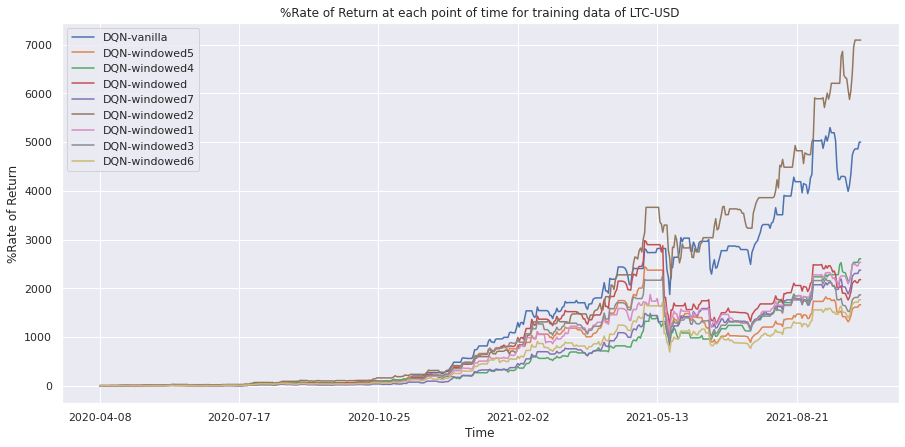

In [48]:
experiment_num = 1
RESULTS_PATH = 'TestResults/Train/'

import os

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

while os.path.exists(f'{RESULTS_PATH}{DATASET_NAME};train;EXPERIMENT({experiment_num}).jpg'):
    experiment_num += 1

fig_file = f'{RESULTS_PATH}{DATASET_NAME};train;EXPERIMENT({experiment_num}).jpg'

sns.set(rc={'figure.figsize': (15, 7)})

items = list(test_portfolios.keys())
random.shuffle(items)

first = True
for k in items:
    profit_percentage = [(train_portfolios[k][i] - train_portfolios[k][0])/train_portfolios[k][0] * 100 
              for i in range(len(train_portfolios[k]))]
    difference = len(train_portfolios[k]) - len(data_loader.data_train_with_date)
    df = pd.DataFrame({'date': data_loader.data_train_with_date.index, 
                       'portfolio':profit_percentage[difference:]})
    if not first:
        df.plot(ax=ax, x='date', y='portfolio', label=k)
    else:
        ax = df.plot(x='date', y='portfolio', label=k)
        first = False

ax.set(xlabel='Time', ylabel='%Rate of Return')
ax.set_title(f'%Rate of Return at each point of time for training data of {DATASET_NAME}')
        
plt.legend()
plt.savefig(fig_file, dpi=300)

### Test Data (Plotted using Seaborn)

In [49]:
# shuffle = False
shuffle = True

The following block plots the results of test portfolios.

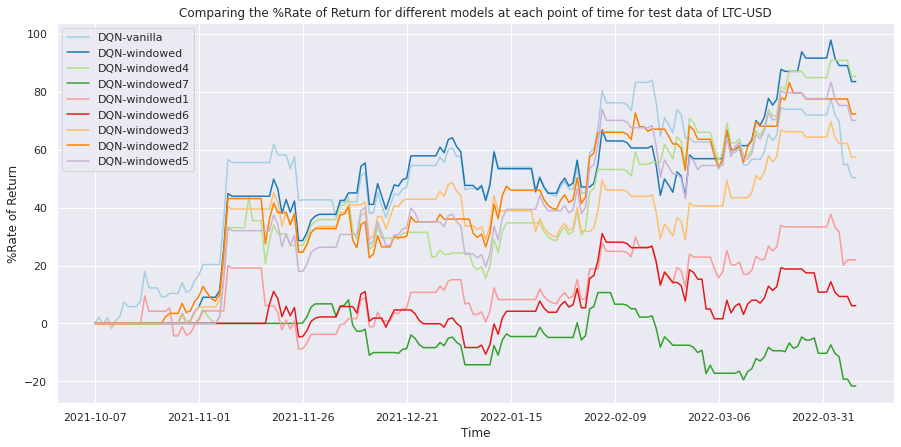

In [50]:
import random

experiment_num = 1
RESULTS_PATH = 'TestResults/Test/'

import os

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

while os.path.exists(f'{RESULTS_PATH}{DATASET_NAME};test;EXPERIMENT({experiment_num}).jpg'):
    experiment_num += 1

fig_file = f'{RESULTS_PATH}{DATASET_NAME};test;EXPERIMENT({experiment_num}).jpg'

sns.set(rc={'figure.figsize': (15, 7)})
sns.set_palette(sns.color_palette("Paired", 15))

items = list(test_portfolios.keys())

if shuffle:
    random.shuffle(items)

first = True
for k in items:
    profit_percentage = [(test_portfolios[k][i] - test_portfolios[k][0])/test_portfolios[k][0] * 100 
                  for i in range(len(test_portfolios[k]))]
    difference = len(test_portfolios[k]) - len(data_loader.data_test_with_date)
    df = pd.DataFrame({'date': data_loader.data_test_with_date.index, 
                       'portfolio':profit_percentage[difference:]})
    if not first:
        df.plot(ax=ax, x='date', y='portfolio', label=k)
    else:
        ax = df.plot(x='date', y='portfolio', label=k)
        first = False
        
ax.set(xlabel='Time', ylabel='%Rate of Return')
ax.set_title(f'Comparing the %Rate of Return for different models '
             f'at each point of time for test data of {DATASET_NAME}')
plt.legend()
plt.savefig(fig_file, dpi=300)

### Test window size

This block plots a line showing the relation between the window-size and the profit in each model.

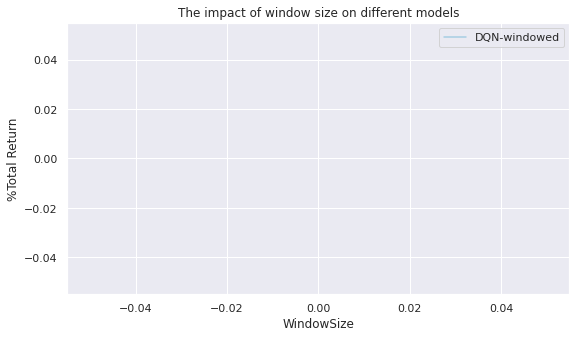

In [23]:
from scipy.interpolate import interp1d
import numpy as np

# 300 represents number of points to make between T.min and T.max
# xnew = np.linspace(3, 75, 300)

experiment_num = 1
RESULTS_PATH = 'TestResults/WindowSize/'

import os

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

while os.path.exists(f'{RESULTS_PATH}{DATASET_NAME};WindowSize;test({experiment_num}).jpg'):
    experiment_num += 1

fig_file = f'{RESULTS_PATH}{DATASET_NAME};WindowSize;test({experiment_num}).jpg'

sns.set(rc={'figure.figsize': (9, 5)})
sns.set_palette(sns.color_palette("Paired", 15))

first = True
for key, val in window_size_experiment.items():
    total_returns = list(val.values())
    
    # Normalize returns:
    total_returns = [(r - min(total_returns))/(max(total_returns) - min(total_returns)) for r in total_returns]
#     f1 = interp1d(window_sizes, total_returns, kind='previous')
    if first:
#         ax = sns.lineplot(xnew, f1(xnew), label=key)
        ax = sns.lineplot(window_sizes, total_returns, label=key)
        first = False
    else:
        sns.lineplot(ax=ax, x=window_sizes, y=total_returns, label=key)
#         sns.lineplot(ax=ax, x=xnew, y=f1(xnew), label=key)
        
ax.set(xlabel='WindowSize', ylabel='%Total Return')
ax.set_title(f'The impact of window size on different models')
plt.legend()
plt.savefig(fig_file, dpi=300)

The following block plots the relation between the window-size and the profit in each model in a heatmap diagram.

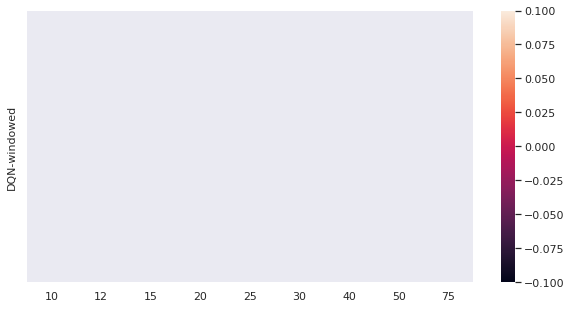

In [39]:
experiment_num = 1
RESULTS_PATH = 'TestResults/WindowSize/'

import os

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

while os.path.exists(f'{RESULTS_PATH}{DATASET_NAME};WindowSize;heatmap;test({experiment_num}).jpg'):
    experiment_num += 1

fig_file = f'{RESULTS_PATH}{DATASET_NAME};WindowSize;heatmap;test({experiment_num}).jpg'

sns.set(rc={'figure.figsize': (10, 5)})

normalized = {}
for k1 in window_size_experiment.keys():
    normalized[k1] = {}
    total_returns = list(window_size_experiment[k1].values())
    max_return = max(total_returns)
    min_return = min(total_returns)
    for k2 in window_size_experiment[k1].keys():
        return_val = window_size_experiment[k1][k2]
        normalized[k1][k2] = (return_val - min_return)/(max_return - min_return)
        

df = pd.DataFrame.transpose(pd.DataFrame.from_dict(normalized))
sns.heatmap(df)

plt.savefig(fig_file, dpi=300)